<a href="https://colab.research.google.com/github/swadhwa5/MLFinalProject/blob/main/ML_FinalProject_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Final Project
By: Shreya Wadhwa, Alan Zhang, Aidan Aug, Trisha Karani
JHED: swadhwa, azhang, tkarani1, aaug1

*Due: April 28th, 2022*

**Description:**

This is the iPython/Jupyter Notebook for our Machine Learning Final Project. For this project, we decided to develop a Majority Vote classifer model over three different CNNs to train a model to recognize sign language letters. The project into the following sections:

1. Required Packages for Running the Notebook

2. Data Augmentation

3. Model Implementation

4. Model Training and Testing

5. Conclusions and Future Works

## Part 1 Python Packages:

This section is simply a compilation of all the required packages for every section in the notebook. Please make sure to run this prior to any of the other code sections.

In [1]:
## Data Processing, Augmentation, and Feature Engineering:
import numpy as np
import random
from PIL import Image, ImageEnhance
from os import listdir
import imghdr
import skimage
from skimage.transform import rotate, AffineTransform, warp

## Model Implementation
import sys
import csv
import os
import numpy as np
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
from skimage.transform import rotate

## Part 2: Data Augmentation and Feature Engineering

For Data Augmentation, we decided to increase our dataset via the following processes:
1. Blur
2. Brighten
3. Rotate
4. Translate
5. Zoom

In [ ]:
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList:
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # only add 5 of each image, only add alphabetical values
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels

# Convert png img array to array np arrays
# Input: PNG image array
# Output: a list of numpy images
# Works?: Yes
def ImagesToArray(imgs):
  imgs_array = []
  for img in imgs:
    img_array = np.array(img)
    imgs_array.append(img_array)
  return imgs_array

# Zero pad all images
# Input: list of numpy images
# Output: numpy array of N 600x600 images with 3 channels
# Works?: Yes, but might not be necessary
def shape600(x):
  reshaped_array = np.zeros((len(x), 600, 600, 3))
  for i, img in enumerate(x):
    x_pad_width = (600 - img.shape[0])//2
    y_pad_width = (600 - img.shape[1])//2
    reshaped_array[i,:,:,:] = np.pad(img, ((x_pad_width, x_pad_width + (img.shape[0])%2), (y_pad_width, y_pad_width+(img.shape[1]%2)), (0,0)), constant_values=img[0][0][0])
  return reshaped_array

# Normalizes images... based on... what?
# Input: image array
# Output: a list of numpy arrays
# Works?: ??? Not entirely sure if this is the correct method though, based on online implementations of AlexNet
def Normalize(imgs):
  new_imgs = []
  for img in imgs:
      # flat_img = img.flatten()
      m = np.mean(img)
      std = np.std(img)
      img = (img-m)/std
      new_imgs.append(img)
  return new_imgs

################### DATA AUGMENTATION ######################
# x is input image, sd is how much to blur
def blur(imgs, sd=1):
  filtered_img = np.zeros((imgs.shape[0], 600, 600, 3))
  for i in range(imgs.shape[0]):
    filtered_img[i,:,:,:] = skimage.filters.gaussian(imgs[i,:,:,:], sigma=sd)
    #filtered_img.save('./Filter_gaussian/img_' + i + '_gaussianfilt.png')
  return filtered_img

def Scale(imgs):
  scaled_images = np.zeros((len(imgs), 600, 600, 3))
  for i, img in enumerate(imgs):
    # ratio = random.randrange(.2, .5, .1)
    ratio = random.choice([0.1, 0.2, 0.3, 0.4])
    x = int(ratio * 600 / 2)
    scaled = img[x:600-x, x:600-x]
    # scaled = cv2.imread(scaled)
    res = cv2.resize(scaled, dsize=(600, 600), interpolation=cv2.INTER_CUBIC)
    scaled_images[i] = res
  return scaled_images
    # final.save('./Crop/img_' + str(i) + '_scale.png')

def Rotate30(imgs): 
  rot30_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    rand_dir = random.choice([-1, 1])
    new_img = rotate(img, rand_dir * 30) 
    rot30_imgs[i, :] = new_img
  return rot30_imgs

def VerticalFlip(imgs): 
  flip_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    new_img = np.fliplr(img)
    flip_imgs[i, :, :, :] = new_img
  return flip_imgs

def Translation(imgs): 
  trans_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    rand_x = random.randrange(-150, 150, 50)
    rand_y = random.randrange(-150, 150, 50)
    transform = AffineTransform(translation=(rand_x,rand_y))
    new_img = warp(img,transform, mode="constant")  
    trans_imgs[i, :] = new_img
  return trans_imgs

Augmentation functions with only one image input

In [ ]:
### Load Data and Handle Preprocessing

# Input: Folder with all the .png images
# Output: Images and respective labels
# Works?: Yes
def loadImages(path):
  imagesList = listdir(path)
  imgs = {}
  for image in imagesList:
    if imghdr.what(path + image) == 'png':
      if (image[6].isalpha()): # only add 5 of each image, only add alphabetical values
        img = Image.open(path + image)
        imgs[image[0:len(image) - 4]] = img
        # labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
  return imgs

# Convert png img array to array np arrays
# Input: PNG image array
# Output: a list of numpy images
# Works?: Yes
def ImagesToArray(imgs):
  imgs_array = {}
  for imgName in imgs.keys():
    img_array = np.array(imgs[imgName])
    imgs_array[imgName] = img_array
  return imgs_array

# Zero pad all images
# Input: list of numpy images
# Output: numpy array of N 600x600 images with 3 channels
# Works?: Yes, but might not be necessary
def shape600(imgs):
  # reshaped_array = np.zeros((len(x), 600, 600, 3))
  reshaped_array = {}
  for imgName in imgs.keys():
    img = imgs[imgName]
    x_pad_width = (600 - img.shape[0])//2
    y_pad_width = (600 - img.shape[1])//2
    # reshaped_array[i,:,:,:] = np.pad(img, ((x_pad_width, x_pad_width + (img.shape[0])%2), (y_pad_width, y_pad_width+(img.shape[1]%2)), (0,0)), constant_values=img[0][0][0])
    new_img = (np.pad(img, ((x_pad_width, x_pad_width + (img.shape[0])%2), (y_pad_width, y_pad_width+(img.shape[1]%2)), (0,0)), constant_values=img[0][0][0])).astype('uint8')
    reshaped_array[imgName] = new_img
  return reshaped_array

# Normalizes images... based on... what?
# Input: image array
# Output: a list of numpy arrays
# Works?: ??? Not entirely sure if this is the correct method though, based on online implementations of AlexNet
def Normalize(imgs):
  new_imgs = []
  for img in imgs:
      # flat_img = img.flatten()
      m = np.mean(img)
      std = np.std(img)
      img = (img-m)/std
      new_imgs.append(img)
  return new_imgs

def blur_1(img, sd=1):
  # filtered_img = np.zeros((imgs.shape[0], 600, 600, 3))
  new_img = skimage.filters.gaussian(img, sigma=sd)
  plt.figure()
  plt.imshow(new_img)
  return new_img

def Scale_1(img):
  # ratio = random.randrange(.2, .5, .1)
  ratio = random.choice([0.1, 0.2, 0.3, 0.4])
  x = int(ratio * 600 / 2)
  scaled = img[x:600-x, x:600-x]
  # scaled = cv2.imread(scaled)
  new_img = cv2.resize(scaled, dsize=(600, 600), interpolation=cv2.INTER_CUBIC)
  return new_img
    

def Rotate30_1(img): 
  # rot30_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  rot30_imgs = {}
  rand_dir = random.choice([-1, 1])
  new_img = rotate(img, rand_dir * 30) 
  return new_img

def VerticalFlip_1(img): 
  # flip_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  flip_imgs = {}
  new_img = np.fliplr(img)
  return new_img

def Translation_1(img): 
  # trans_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  rand_x = random.randrange(-150, 150, 50)
  rand_y = random.randrange(-150, 150, 50)
  transform = AffineTransform(translation=(rand_x,rand_y))
  new_img = warp(img,transform, mode="constant")
  return new_img
####################################################


Apply multiple augmentations to one image

In [ ]:
# create test set with data augmentations
images = imgs_array_reshaped
for this_img in images.items(): 
  num_aug = random.choice([1, 2, 3])
  new_img = this_img[1]
  img_save = Image.fromarray(new_img, 'RGB')
  img_save.save(save_path + this_img[0] + '_aug_temp' + '.png')
  
  num_list = list(range(0, 5)) 
  random.shuffle(num_list)
  name = ''
  for n in range(num_aug): 
    this_aug = num_list[n]
    new_img = Image.open(save_path + this_img[0] + '_aug_temp' + '.png')
    new_img = np.array(new_img)

    if (this_aug == 0): 
      new_img = blur_1(new_img, 10)
      name += '_blurred'
      img_save = Image.fromarray((new_img * 255).astype('uint8'), 'RGB')
    elif (this_aug == 1): 
      new_img = Scale_1(new_img)
      name += '_scaled'
      img_save = Image.fromarray(new_img, 'RGB')
    elif (this_aug == 2): 
      new_img = Rotate30_1(new_img)
      name += '_rotated'
      img_save = Image.fromarray((new_img * 255).astype('uint8'), 'RGB')
    elif (this_aug == 3): 
      new_img = VerticalFlip_1(new_img)
      name += '_flipped'
      img_save = Image.fromarray(new_img, 'RGB')
    elif (this_aug == 4): 
      new_img = Translation_1(new_img)
      name += '_translated'
      img_save = Image.fromarray((new_img * 255).astype('uint8'), 'RGB')
    
    img_save.save(save_path + this_img[0] + '_aug_temp' + '.png')

  img_save.save(save_path + this_img[0] + '_aug' + name + '.png');

## Part 3: Model Implementation

For our model, we decided to implement a majority vote classifier based on three Convolutional Neural Networks, each with differing structures. Each model structure has basis in other current models.

### Model 1: LeNet with 3 Channels

LeNet was one of the first convolutional neural network (CNN) models used on 28x28 black and white images. While it is simple, it was one of the first uses of the backpropgation algorithm in practical applications: specifically, reading handwritten numbers. In 1990, there was an error rate of 1% and rejection rate of about 9%. The model structure is as follows:
1. 2 convolutional layers
2. 2 pooling layers
3. 3 fully-connected

In this implementation, we make slight modifications to this network and apply it to RGB images.

LeCun, Y.; Boser, B.; Denker, J. S.; Henderson, D.; Howard, R. E.; Hubbard, W. & Jackel, L. D. (1989). Backpropagation applied to handwritten zip code recognition. Neural Computation, 1(4):541-551.[1]

In [2]:
import numpy as np
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
from skimage.transform import rotate
import matplotlib.pyplot as plt

In [3]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout layer for regularization
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(84, num_classes) # must output num_classes; like softmax
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.linear(x)
        return x

### Model 2: AlexNet

AlexNet was one of the breakthrough CNN models that competed and won the ImageNet Large Scale Visual Recognition Challenge in 2021. The model achieved an error of 15.3%, which was greatly better than the runner-up error. The following is an implementation for this CNN.

In [4]:
# AlexNet Implementation
# Expects input of size 227 at least, for the kernels to work

class AlexNet(torch.nn.Module):
    def __init__(self, input_height=227, input_width=227, n_classes=26, channels=3):
        super().__init__()

        # Initialize the parameters of the model
        self.input_height = input_height
        self.input_width = input_width
        self.n_classes = n_classes
        self.channels = channels

        # AlexNet Implementation; Same Structure with different outputs die to input
        self.model_convolution = nn.Sequential(
            nn.Conv2d(in_channels=channels,out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2)
        )

        # The dense network architecture. Assumes input has 4096 nodes, or 4x4x256
        self.model_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.2), # Regularization
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], self.channels, self.input_height, self.input_width)
        x = self.model_convolution(x)
        x = self.model_dense(x)
        return x
    
        

### Additional Functions Related to Processing

In [5]:
import torch
import numpy as np
import torch.nn.functional as F


def accuracy(y : np.ndarray, y_hat : np.ndarray) -> np.float64:
    """Calculate the simple accuracy given two numpy vectors, each with int values
    corresponding to each class.

    Args:
        y (np.ndarray): actual value
        y_hat (np.ndarray): predicted value

    Returns:
        np.float64: accuracy
    """
    N = len(y)   
    number_correct = N - np.count_nonzero(y - y_hat)
    accuracy = number_correct / N
    return accuracy


def approx_train_acc_and_loss(model, train_data : np.ndarray, train_labels : np.ndarray) -> np.float64:
    """Given a model, training data and its associated labels, calculate the simple accuracy when the 
    model is applied to the training dataset.
    This function is meant to be run during training to evaluate model training accuracy during training.

    Args:
        model (pytorch model): model class object.
        train_data (np.ndarray): training data
        train_labels (np.ndarray): training labels

    Returns:
        np.float64: simple accuracy
    """
    idxs = np.random.choice(len(train_data), 1, replace=False)
    x = torch.from_numpy(train_data[idxs].astype(np.float32))
    y = torch.from_numpy(train_labels[idxs])
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
      
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(train_labels[idxs], y_pred.cpu().numpy()), loss.item()


def dev_acc_and_loss(model, dev_data : np.ndarray, dev_labels : np.ndarray) -> np.float64:
    """Given a model, a validation dataset and its associated labels, calcualte the simple accuracy when the
    model is applied to the validation dataset.
    This function is meant to be run during training to evaluate model validation accuracy.

    Args:
        model (pytorch model): model class obj
        dev_data (np.ndarray): validation data
        dev_labels (np.ndarray): validation labels

    Returns:
        np.float64: simple validation accuracy
    """
    dev_labels = np.asarray(dev_labels)

    x = torch.from_numpy(dev_data.astype(np.float32))
    y = torch.from_numpy(dev_labels.astype(int))
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    y_pred = y_pred.cpu()
    return accuracy(dev_labels, y_pred.numpy()), loss.item()

In [18]:
# Train the model parameters
def train_model(trainloader, train_data, train_labels, dev_data, dev_labels, criterion, optimizer, model, num_images, n=20):

  for epoch in range(n):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if epoch % 2 == 0:
        train_acc, train_loss = approx_train_acc_and_loss(model, train_data, train_labels)
        dev_acc, dev_loss = dev_acc_and_loss(model, dev_data, dev_labels)
        step_metrics = {
                'step': epoch, 
                'train_loss': loss.item(), 
                'train_acc': train_acc,
                'dev_loss': dev_loss,
                'dev_acc': dev_acc
            }

        print(f"On step {epoch}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")

  print('Finished Training')

# # Test the model on help out dev set
# def test_model(testloader, labels1, test_data, model):
#     correct = 0
#     total = 0
#     misclass_ind = []
#     incorrect_imgs = []
#     incorrect_labels = []
#     predicted_labels = []
#     # since we're not training, we don't need to calculate the gradients for our outputs
#     with torch.no_grad():
#         for data in testloader:
#             images, labels = data
#             if torch.cuda.is_available():
#               images = images.cuda()
#               labels = labels.cuda()
#             # calculate outputs by running images through the network
#             outputs = model(images)
#             # the class with the highest energy is what we choose as prediction
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels).sum().item() # Calculate number correct
#             if ((predicted != labels).sum().item()) > 0:
#                 incorrect = predicted - labels
#                 for i in range(len(incorrect)):
#                     if incorrect[i] != 0:
#                         incorrect_imgs.append(images[i])
#                         misclass_ind.append(total + i)
#                         incorrect_labels.append(labels1[i + total])
#                         predicted_labels.append(predicted[i])

                    
#             total += labels.size(0) # for each batch (size=4), predict the labels

#     print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
#     incorrect_images = test_data[misclass_ind]
#     imshow(torchvision.utils.make_grid(incorrect_imgs))
#     print("Actual labels: " +
#           ' '.join(f'{classes[incorrect_labels[j]]:5s}' for j in range(len(incorrect_labels))))
#     print("predicted labels: " +
#           ' '.join(f'{classes[predicted[j]]:5s}' for j in range(len(incorrect_labels))))

#     return correct, total, misclass_ind

# Test the model on help out dev set
def test_model(testloader, labels1, test_data, model, num_display=0):
    correct = 0
    total = 0
    misclass_ind = []
    incorrect_imgs = []
    incorrect_labels = []
    predicted_labels = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available():
              images = images.cuda()
              labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item() # Calculate number correct
            if ((predicted != labels).sum().item()) > 0:
                incorrect = predicted - labels
                for i in range(len(incorrect)):
                    if incorrect[i] != 0:
                        incorrect_imgs.append(images[i])
                        misclass_ind.append(total + i)
                        incorrect_labels.append(labels1[i + total])
                        predicted_labels.append(predicted[i])

                    
            total += labels.size(0) # for each batch (size=4), predict the labels

    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
    incorrect_images = torch.Tensor(test_data[misclass_ind]).cpu()
    if num_display < len(incorrect_images):
      incorrect_images = incorrect_images[0:num_display]
    imshow(torchvision.utils.make_grid(incorrect_images))
    print("Actual labels: " +
          ' '.join(f'{classes[incorrect_labels[j]]:5s}' for j in range(num_display)))
    print("predicted labels: " +
          ' '.join(f'{classes[predicted_labels[j]]:5s}' for j in range(num_display)))

    return correct, total

In [7]:
# Input: One normalized image
# Output: None
# Plots the image, assumed to be [3, x_dim, y_dim]
def imshow(img):
  # Unnormalize the image before showing!
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ]),
                                  ])
    img = invTrans(img.cpu())
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# Step 3: Visualize how some of the images look after processing the data
def visualize_images(trainloader, num_display, batch_size, xdim, ydim):
    dataiter = iter(trainloader)
    images = torch.empty((num_display * batch_size, channels, xdim, ydim))
    labels = torch.empty((num_display * batch_size), dtype=torch.uint8)
    #images, labels = dataiter.next()

    start_index = 0
    stop_index = batch_size
    for i in range(num_display):
        image, label = dataiter.next()
        images[start_index:stop_index, :, :, :] = image
        labels[start_index:stop_index] = label
        start_index = stop_index
        stop_index += batch_size

    imshow(torchvision.utils.make_grid(images))
    # print labels
    print("labels: " +
          ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_display * batch_size)))



# Show number_batches * display_num images
def show_true_vs_predicted(testloader, classes, model, num_batches, batch_size):
    # print images
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_batches * batch_size)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_batches * batch_size)))


# def show_incorrect(misclass_ind, images, labels, model, num_display=1):
#     if (len(misclass_ind) != 0):
#       print(type(labels))
#       incorrect_imgs = torch.Tensor(images[misclass_ind])
#       true_labels = labels[misclass_ind]
#       if torch.cuda.is_available():
#         incorrect_imgs = incorrect_imgs.cuda()
        
#         model = model.to("cuda")
      

#       outputs = model(incorrect_imgs)
#       _, predicted = torch.max(outputs, 1)

#       idxs = np.random.choice(len(incorrect_imgs), num_display)

#       incorrect_imgs = incorrect_imgs.cpu()
#       # true_labels = true_labels[idxs]
#       # predicted = predicted[idxs]

#       imshow(torchvision.utils.make_grid(incorrect_imgs))
#       print("Actual labels: " +
#             ' '.join(f'{classes[true_labels[j]]:5s}' for j in range(num_display)))
#       print("predicted labels: " +
#             ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_display)))

## Part 4: Training, Testing

Here, we actually train and test the model on the provided datasets.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string

import imghdr
from PIL import Image
from os import listdir

In [9]:
# Input: Path to a folder of .png files. Let #=dataset num, l = letter represented, v=variation, a=augmentation
#     Must be structured s.t. hand#_l_v_a.png
# Output: List of .png images and their respective labels
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList: # iterate over all images in the folder
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # 6th position is the letter
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels

# Input: the images list (3 channels), crop size, and resize hyperparameters
# Output: a tensor array of all the reshaped + resized images
def applyTransforms(imgs, crop_size, resize):
  # Define the necessary preprocessing transforms
  num_imgs = len(imgs)
  preprocess = transforms.Compose([
    transforms.Resize(resize), # Hyperparameter
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  # Create tensor array
  transforms_array = np.zeros((num_imgs, 3, crop_size, crop_size))
  for i in range(num_imgs):
    temp = preprocess(imgs[i])
    transforms_array[i,:,:,:] = temp
  
  return transforms_array

# Input: list of .png images, their labels, and other default parameters
# Output: None
# Plots the image, assumed to be [3, x_dim, y_dim]
def test_loader(test_data, test_labels, batch_size=4):
    # Create the testing data and testloader    
    test_data_and_labels = []
    for i in range(len(test_data)):
        sample = (torch.Tensor(test_data[i, :, :, :]), test_labels[i])
        test_data_and_labels.append(sample)

    testloader = torch.utils.data.DataLoader(test_data_and_labels, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

    test_labels = np.asarray(test_labels)
    return test_data, test_labels, testloader

# Input: an image tensor [num_imgs, channels, x_dim, y_dim], test split, and a batch size
# Output: a tensor array of all the reshaped + resized images
def train_dev_test_loaders(transforms_array, labels, test_split=0.2, batch_size=4):
  ## Create the training dataand trainloader
  train_data, dev_data, train_labels, dev_labels = train_test_split(transforms_array, labels, test_size=test_split, random_state=42)

  dev_data, test_data, dev_labels, test_labels = train_test_split(dev_data, dev_labels, test_size=0.5, random_state=42)

  train_data_and_labels = []
  for i in range(len(train_data)):
    sample = (torch.Tensor(train_data[i,:,:,:]), train_labels[i])
    train_data_and_labels.append(sample)

  trainloader = torch.utils.data.DataLoader(train_data_and_labels, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

  ## Create the developmental data and devloader
  dev_data_and_labels = []
  for i in range(len(dev_data)):
    sample = (torch.Tensor(dev_data[i,:,:,:]), dev_labels[i])
    dev_data_and_labels.append(sample)

  devloader = torch.utils.data.DataLoader(dev_data_and_labels, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
  
  ## Create the Test data and testloader
  test_data_and_labels = []
  for i in range(len(test_data)):
    sample = (torch.Tensor(test_data[i,:,:,:]), test_labels[i])
    test_data_and_labels.append(sample)

  testloader = torch.utils.data.DataLoader(test_data_and_labels, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
  train_labels = np.asarray(train_labels)
  dev_labels = np.asarray(dev_labels)
  test_labels = np.asarray(test_labels)
  return [train_data, train_labels, trainloader, dev_data, dev_labels, devloader, test_data, test_labels, testloader]


### LeNet: Training, Testing, and Analysis!

Step 1: First, we load in our datasets and apply the necessary transformations

In [10]:
from google.colab import drive
drive.mount('/content/drive')

orig_data_path = "/content/drive/MyDrive/Machine_Learning_Datasets/Data_full/"
aug_data_path = "/content/drive/MyDrive/Machine_Learning_Datasets/FinalImages/"
mult_augments_path = "/content/drive/MyDrive/Machine_Learning_Datasets/Only_Mult_Augments/"

Mounted at /content/drive


In [11]:
### Get all the datasets... this takes a while though lmao

orig_imgs, orig_labels = loadImages(orig_data_path)
aug_imgs, aug_labels = loadImages(aug_data_path)
mult_aug_imgs, mult_aug_labels = loadImages(mult_augments_path)

print(f"Total number of images in Orig Dataset is: {len(orig_imgs)}")
print(f"Total number of images in Aug Dataset is: {len(aug_imgs)}")
print(f"Total number of images in Mult_Aug Dataset is: {len(mult_aug_imgs)}")

Total number of images in Orig Dataset is: 650
Total number of images in Aug Dataset is: 3900
Total number of images in Mult_Aug Dataset is: 650


In [12]:
### Add additional comments for LeNet
batch_size = 4
channels = 3
xdim = 32
ydim = 32

In [13]:
# Preprocess the data to feed into LeNet 32x32
transforms_array_train = applyTransforms(orig_imgs, crop_size=xdim, resize=15)
[train_data, train_labels, trainloader, dev_data, dev_labels, devloader, 
 test_data, test_labels, testloader] = train_dev_test_loaders(transforms_array_train, orig_labels, test_split=0.2, batch_size=batch_size)

In [14]:
lr = 0.001
classes = list(string.ascii_uppercase) # A-Z
lenet_no_aug = LeNet(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_no_aug.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_no_aug.to(device);

In [15]:
train_model(trainloader, train_data, train_labels, dev_data, dev_labels, criterion, optimizer, lenet_no_aug, num_images=len(train_data), n=30)


On step 0:	Train loss 3.4557251930236816	|	Dev acc is 0.046153846153846156
On step 2:	Train loss 2.936171531677246	|	Dev acc is 0.12307692307692308
On step 4:	Train loss 0.02688653953373432	|	Dev acc is 0.49230769230769234
On step 6:	Train loss 0.08580286055803299	|	Dev acc is 0.5846153846153846
On step 8:	Train loss 0.018860995769500732	|	Dev acc is 0.6307692307692307
On step 10:	Train loss 0.99571692943573	|	Dev acc is 0.6461538461538462
On step 12:	Train loss 0.02243693359196186	|	Dev acc is 0.7538461538461538
On step 14:	Train loss 0.004838187713176012	|	Dev acc is 0.8153846153846154
On step 16:	Train loss 1.5180144309997559	|	Dev acc is 0.8615384615384616
On step 18:	Train loss 0.39372748136520386	|	Dev acc is 0.8461538461538461
On step 20:	Train loss 0.016498565673828125	|	Dev acc is 0.8461538461538461
On step 22:	Train loss 0.008404836058616638	|	Dev acc is 0.8769230769230769
On step 24:	Train loss 1.311301275563892e-06	|	Dev acc is 0.8769230769230769
On step 26:	Train loss 0.01

Evalating on the held-out test set...
Accuracy of the network on the 65 test images: 86 %


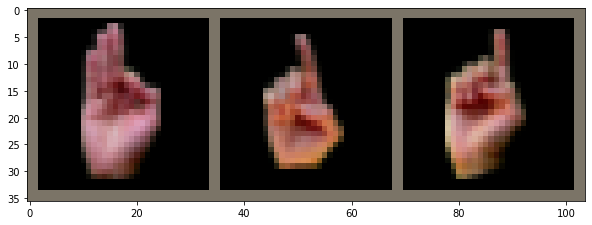

Actual labels: F     D     D    
predicted labels: E     Z     U    
Correct: 56 
Total: 65


In [20]:
print("Evalating on the held-out test set...")
correct, total = test_model(testloader, test_labels, test_data, lenet_no_aug, num_display=3)
print(f"Correct: {correct} \nTotal: {total}")



In [ ]:
# Save the model!
torch.save(lenet_no_aug.state_dict(), "/content/drive/MyDrive/Machine_Learning_Datasets/models/lenet_no_aug_650")


#### Now, apply the same process on the Data-Augmented Dataset

In [21]:
# Preprocess the data to feed into LeNet 32x32
transforms_array_dataAug = applyTransforms(aug_imgs, crop_size=32, resize=35)
[train_data, train_labels, trainloader, dev_data, dev_labels, devloader, 
 test_data, test_labels, testloader] = train_dev_test_loaders(transforms_array_dataAug, aug_labels, test_split=0.2, batch_size=batch_size)

In [22]:
# Step 4: Declare the loss function and optimizer for training

lr = 0.001  # Too large suboptimal convergence. Too small is process gets stuck. Find a balance
lenet_with_aug = LeNet(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_with_aug.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_with_aug.to(device);

In [23]:
train_model(trainloader, train_data, train_labels, dev_data, dev_labels, criterion, optimizer,
            lenet_with_aug, num_images=len(train_data), n=30)


On step 0:	Train loss 2.549604892730713	|	Dev acc is 0.21794871794871795
On step 2:	Train loss 1.8566036224365234	|	Dev acc is 0.5
On step 4:	Train loss 0.9714014530181885	|	Dev acc is 0.5923076923076923
On step 6:	Train loss 0.6193727850914001	|	Dev acc is 0.676923076923077
On step 8:	Train loss 4.756337511935271e-05	|	Dev acc is 0.6974358974358974
On step 10:	Train loss 0.0018964892951771617	|	Dev acc is 0.7256410256410256
On step 12:	Train loss 1.7165990357170813e-05	|	Dev acc is 0.7307692307692307
On step 14:	Train loss 0.5767432451248169	|	Dev acc is 0.7615384615384615
On step 16:	Train loss 0.18687860667705536	|	Dev acc is 0.7435897435897436
On step 18:	Train loss 1.2874520507466514e-05	|	Dev acc is 0.7897435897435897
On step 20:	Train loss 8.02538776397705	|	Dev acc is 0.7717948717948718
On step 22:	Train loss 0.0016559947980567813	|	Dev acc is 0.7717948717948718
On step 24:	Train loss 0.0	|	Dev acc is 0.7666666666666667
On step 26:	Train loss 0.004816477652639151	|	Dev acc is 0

Evalating on the held-out test set...
Accuracy of the network on the 390 test images: 80 %


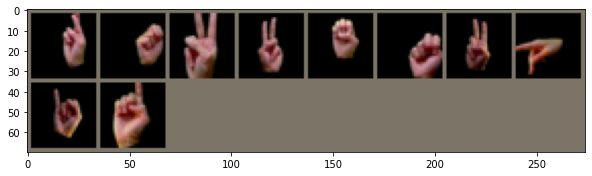

Actual labels: R     N     V     V     E     N     V     P     J     D    
predicted labels: W     D     W     R     J     S     W     H     G     F    
Correct: 314 
Total: 390


In [24]:
print("Evalating on the held-out test set...")
correct, total = test_model(testloader, test_labels, test_data, lenet_with_aug, num_display=10)
print(f"Correct: {correct} \nTotal: {total}")


In [25]:
# Save the model!
torch.save(lenet_with_aug.state_dict(), "/content/drive/MyDrive/Machine_Learning_Datasets/models/lenet_with_aug_3900")


#### Compare the performance on some "real-world" data

In [26]:
transforms_array_test_data = applyTransforms(mult_aug_imgs, crop_size=32, resize=35)
test_data, test_labels, testloader = test_loader(transforms_array_test_data, mult_aug_labels)

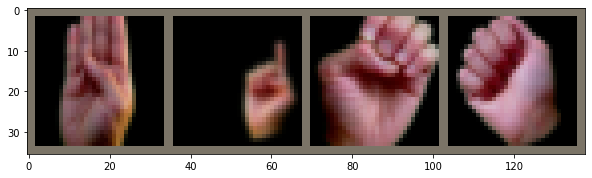

labels: B     D     E     A    


In [27]:
# Step 1: Visualize how some of the images look after processing the data
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


Accuracy of the network on the 650 test images: 18 %


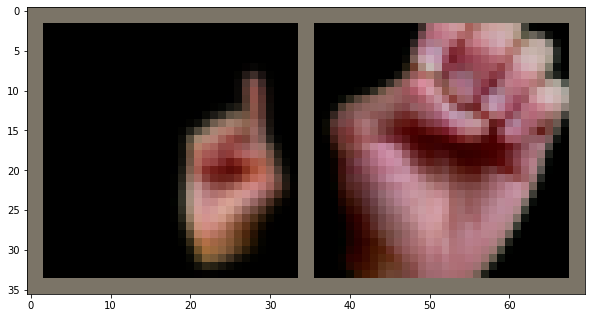

Actual labels: D     E    
predicted labels: X     M    


In [29]:
# Let's use the no augmentation to observe training time
lenet_no_aug = LeNet(len(classes))
lenet_no_aug.load_state_dict(torch.load("/content/drive/MyDrive/Machine_Learning_Datasets/models/lenet_no_aug_650"))
lenet_no_aug.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_no_aug.to(device);

correct, total = test_model(testloader, test_labels, test_data, lenet_no_aug, num_display=2)


Accuracy of the network on the 650 test images: 60 %


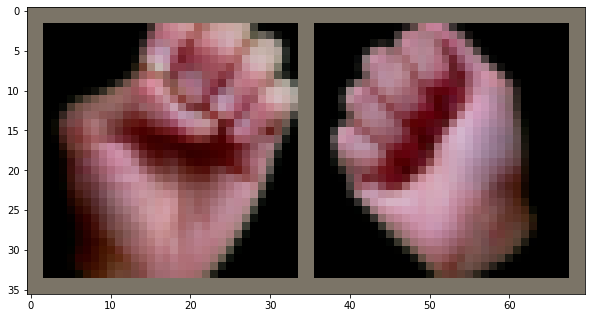

Actual labels: E     A    
predicted labels: Y     S    


In [31]:
lenet_with_aug = LeNet(len(classes))
lenet_with_aug.load_state_dict(torch.load("/content/drive/MyDrive/Machine_Learning_Datasets/models/lenet_with_aug_3900"))
lenet_with_aug.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_with_aug.to(device);

correct, total = test_model(testloader, test_labels, test_data, lenet_with_aug, num_display=2)




### AlexNet: Training, Testing, and Analysis!

Same process, but now with alexnet!

#Model 3: ResNet Basis

In 2015, the next field-shaking model to be proposed for image classification was ResNet. One major issue for training models with many hidden layers is the vanishing gradient problem. ResNet, through a skip-layer structure, also called an "identity shortcut connection," avoids this problem.

In [ ]:
# We use CNN blocks, which are multiple CNNs, multiple times.
class CNNblock(nn.Module):
    def __init__(self, in_chan, interm_chan, identity_downsample=None, stride=1):
        super(CNNblock, self).__init__()
        self.expansion = 4 # Hyperparameter for tuning

        self.model_convolution = nn.Sequential(
            nn.Conv2d(in_chan, interm_chan, kernel_size=1),
            nn.BatchNorm2d(interm_chan),
            nn.Conv2d(interm_chan, interm_chan, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(interm_chan),
            nn.Conv2d(interm_chan, interm_chan * self.expansion, kernel_size=1),
            nn.BatchNorm2d(interm_chan * self.expansion),
            nn.ReLU()
        )
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.model_convolution(x)

        # Skip Connection
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.model_convolution = torch.nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(
          block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
          block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
          block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
          block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)


    def forward(self, x):
      x = self.model_convolution(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      x = x.reshape(x.shape[0], -1)
      x = self.fc(x)

      return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
      identity_downsample = None
      layers = []

      # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
      # we need to adapt the Identity (skip connection) so it will be able to be added
      # to the layer that's ahead

      if stride != 1 or self.in_channels != intermediate_channels * 4:
        identity_downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, intermediate_channels * 4, kernel_size=1, stride=stride),
          nn.BatchNorm2d(intermediate_channels * 4),
        )
        layers.append(
          block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

      # The expansion size is always 4 for ResNet 50,101,152
      self.in_channels = intermediate_channels * 4

      # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
      # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
      # and also same amount of channels.
      
      for i in range(num_residual_blocks - 1):
        layers.append(block(self.in_channels, intermediate_channels))
      return nn.Sequential(*layers)

def ResNet50(img_channel=3, num_classes=1000):
  return ResNet(CNNblock, [3, 4, 6, 3], img_channel, num_classes)

def test():
    net = ResNet50(img_channel=3, num_classes=1000)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    y = net(torch.randn(4, 3, 224, 224)).to(device)
    print(y.size())

test()


### Model 3: Inception



Citations:

ResNet:
https://www.analyticsvidhya.com/blog/2021/06/build-resnet-from-scratch-with-python/

